# <center> **Validation of Bounded Divergence** <center>

In [2]:
from src import *
import numpy as np
import torch
import torch.nn.functional as F
from scipy.stats import wasserstein_distance
from tqdm import tqdm
from statistics import mean, stdev
import matplotlib.pyplot as plt
import pickle

import matplotlib.lines as mlines
import matplotlib.ticker as mticker
from mpl_toolkits.mplot3d import Axes3D

## Define parameters

In [3]:
data_percentage = [10, 20, 30, 40, 50]
class_size = [4, 10]
n_folds = 5

# hyperparameters of one-shot generative model
target_size = len(np.load('./data/C4P10K1/X_train.npy'))
patch_dims = [5, 7, 9]
min_height = 15

# hyperparameters of bound validation
n = 45.0
n_prime_list = [5, 10, 15, 20, 25, 30, 35, 40]

## Generate by one-shot generative model (GPDM)

In [ ]:
utils.set_seeds(seed_value=0)
for patch_dim in patch_dims:
    g = generate.Vicinal(patch_dim = patch_dim, min_height = min_height)
    for cs in class_size:
        for dp in data_percentage:
            for fold in range(n_folds):
                print(cs, ' Classes, ', dp, ' Percent, ', 'Fold ', fold)
                X_train_subsampled = np.load(paths_dict[(cs, dp)][fold][0])
                Y_train_subsampled = np.load(paths_dict[(cs, dp)][fold][1])
                X_train_synthetic, Y_train_synthetic = g.generate(X_train_subsampled, Y_train_subsampled, target_size)

                # Create the folder if it doesn't exist
                folder_path = f'./results/gpdm{patch_dim}_s/C{cs}P{dp:02d}K{fold + 1}/'
                os.makedirs(folder_path, exist_ok=True)

                # Save the synthetic data
                np.save(os.path.join(folder_path, 'X_train_synthetic.npy'), X_train_synthetic)
                np.save(os.path.join(folder_path, 'Y_train_synthetic.npy'), np.squeeze(Y_train_synthetic))

## Estimate the value of $W$ and $\delta$

In [ ]:
# Create the folder if it doesn't exist
folder_path = f'./results/bounds/'
os.makedirs(folder_path, exist_ok=True)

utils.set_seeds(seed_value=0)
total_iterations = len(class_size) * len(data_percentage) * n_folds * len(n_prime_list)
pu = utils.PatchUtils()
paths_dict_train = utils.get_sorted_paths_dict(data_directory  = f'./data',substring_to_replace = 'train')
for patch in patch_dims:
    paths_dict_train_synthetic = utils.get_sorted_paths_dict(data_directory  = f'./results/gpdm{patch}_s',substring_to_replace = 'train_synthetic')
    with tqdm(total=total_iterations, desc="Overall Progress") as pbar:
        swd_dict = {}; d_dict = {}
        for (C, P), path_list in paths_dict_train_synthetic.items():
            for K, (x_path, _) in enumerate(path_list):
                X_r = np.load(paths_dict_train[(C,P)][0][0]); X_r_2d = np.reshape(X_r,(-1,45,45))
                X_g = np.load(x_path); X_g_2d = np.reshape(X_g,(-1,45,45))
                swd = pu.sliced_wasserstein_distance(X_r, X_g)
                swd_dict[(C, P, K)] = swd
                for n_prime in n_prime_list:
                    d = pu.expected_patch_distribution_distance(X_r_2d, X_g_2d, n_prime)
                    d_dict[(C, P, K, n_prime)] = d
                    pbar.update(1)
    # Organize values
    ratio_values_dict = {}
    for (C, P, K, n_prime), d_value in d_dict.items():
        swd_value = swd_dict.get((C, P, K), 1)
        ratio = swd_value / d_value

        key = (C, P, n_prime)
        if key not in ratio_values_dict:
            ratio_values_dict[key] = []
        ratio_values_dict[key].append(ratio)

    # Calculate mean and standard deviation
    mean_ratio_dict = {}
    std_ratio_dict = {}

    for key, values in ratio_values_dict.items():
        mean_ratio_dict[key] = mean(values)
        std_ratio_dict[key] = stdev(values)

    # Saving mean_ratio_dict
    with open(f'./results/bounds/mean_ratio_dict_patch{patch}.pkl', 'wb') as file:
        pickle.dump(mean_ratio_dict, file)

    # Saving std_ratio_dict
    with open(f'./results/bounds/std_ratio_dict_patch{patch}.pkl', 'wb') as file:
        pickle.dump(std_ratio_dict, file)    

## Plot the ratio of $W/\delta$ against its theoretical upperbound

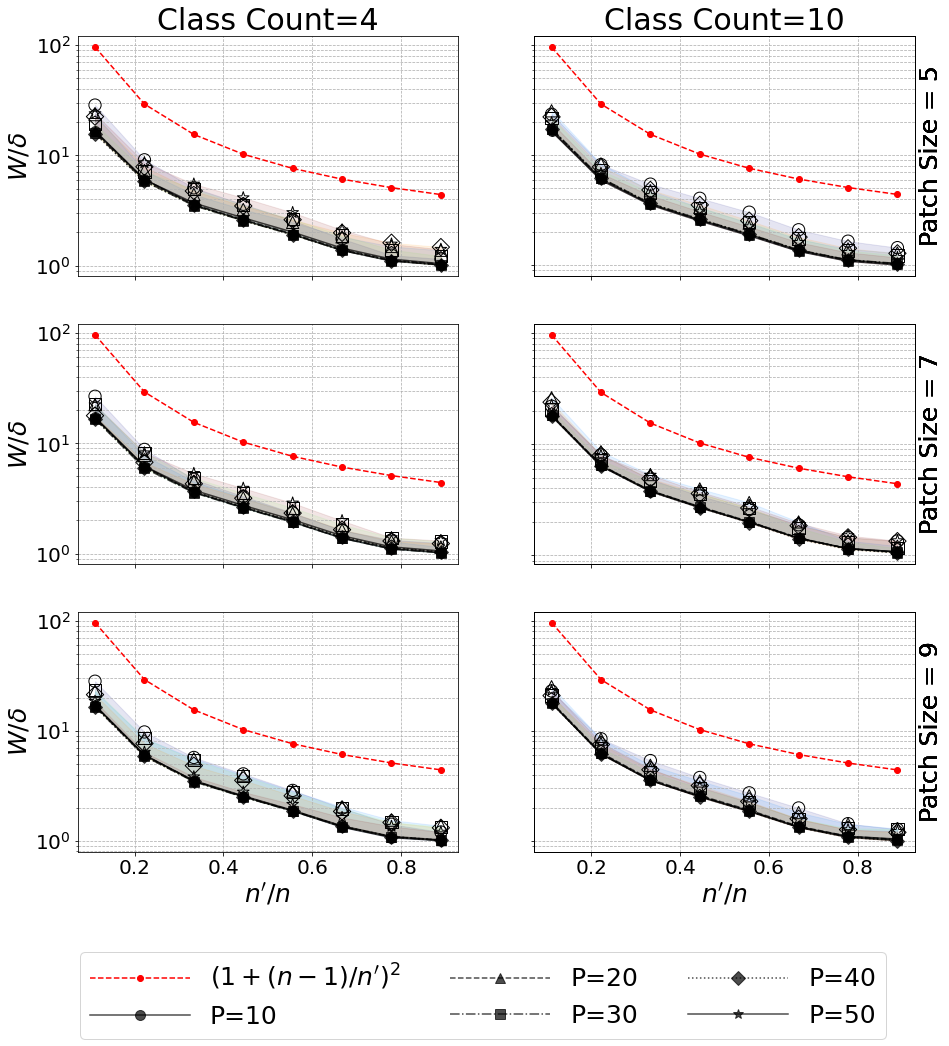

In [4]:
# Adjusting global font sizes
plt.rcParams['font.size'] = 20         # Default font size
plt.rcParams['axes.titlesize'] = 30    # Axes title font size
plt.rcParams['axes.labelsize'] = 25    # X and Y axis label font size
plt.rcParams['xtick.labelsize'] = 20   # X axis tick labels
plt.rcParams['ytick.labelsize'] = 20   # Y axis tick labels
plt.rcParams['legend.fontsize'] = 25   # Legend font size

# Create subplots
fig, axes = plt.subplots(nrows=len(patch_dims), ncols=len(class_size), figsize=(15, 15))

for rowidx, patch in enumerate(patch_dims):
# Loading mean_ratio_dict
    with open(f'./results/bounds/mean_ratio_dict_patch{patch}.pkl', 'rb') as file:
        mean_ratio_dict = pickle.load(file)

    # Loading std_ratio_dict
    with open(f'./results/bounds/std_ratio_dict_patch{patch}.pkl', 'rb') as file:
        std_ratio_dict = pickle.load(file)

    x_axis = np.zeros((len(n_prime_list)))
    for i in range(len(n_prime_list)):
        x_axis[i]=n_prime_list[i]/n

    line_styles = ['-', '--', '-.', ':']

    marker = ['o', '^', 's', 'D', '*']
    colors = plt.cm.jet(np.linspace(0, 1, len(data_percentage)))

    for colidx, C in enumerate(class_size):
        ax = axes[rowidx,colidx]
        
        # Series 2: (n-1 / n_prime + 1) ^ 2
        y2 = [((n-1)/float(n_prime)+1)**2 for n_prime in n_prime_list]
        ax.semilogy(x_axis, y2, 'r--', label=f'$(1+(n-1)/n\')^2$', marker=".", markersize=12)
        for j, P in enumerate(data_percentage):
            y_values = [mean_ratio_dict.get((C, P, n_prime), 0) for n_prime in n_prime_list]
            y_std = [std_ratio_dict.get((C, P, n_prime), 0) for n_prime in n_prime_list]

            upper_bound = [y + 10*e for y, e in zip(y_values, y_std)]
            lower_bound = [y - 0*e for y, e in zip(y_values, y_std)]

            # Plotting the mean ratio with diversified styles and colors
            ax.semilogy(x_axis, y_values, label=f'P={P}', 
                        linestyle=line_styles[j % len(line_styles)],
                        marker = marker[j % len(marker)],
                        color='k', alpha=0.7, markersize=10)
            ax.grid(True, which='both', linestyle='--', linewidth=0.75)

            # Using fill_between to shade the region between mean - std and mean + std
            ax.fill_between(x_axis, lower_bound, upper_bound, color=colors[j], alpha=0.1)


            # Adding markers for the fill boundaries
            ax.scatter(x_axis, upper_bound, facecolors='none', edgecolors='k', marker=marker[j % len(marker)], s=150, zorder=3)

            if rowidx == 0:
                ax.set_title(f'Class Count={C}')
            if rowidx == len(patch_dims)-1:
                ax.set_xlabel('$n\'/n$')
            else:
                ax.set_xticklabels([])
            if colidx == 0:
                ax.set_ylabel('$W/\delta$')
            else:
                ax.set_yticklabels([])
                
            # Create a secondary y-axis for the rightmost column
            if colidx == len(class_size) - 1:  # Check if it's the rightmost column
                ax_right = ax.twinx()  # Create a secondary y-axis
                ax_right.set_ylabel(f'Patch Size = {patch}' )
                ax_right.set_yticks([])  # Optionally set or adjust the y-ticks

# Create a single legend for the entire figure
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.06), ncol=3 , handlelength=4)
plt.savefig('bounds.pdf', format='pdf', bbox_inches='tight')